In [222]:
library(MASS)
library(readr)
library(ggplot2)
library(corrplot)
library(mlbench)
library(Amelia)
#library(plotly)
library(reshape2)
#library(caret)
library(caTools)
library(dplyr)
library(caret)
library(tidyr)
library(readr)

In [223]:
house_data_raw = read_csv("data/train.csv")

Parsed with column specification:
cols(
  .default = col_character(),
  Id = col_integer(),
  MSSubClass = col_integer(),
  LotArea = col_integer(),
  OverallQual = col_integer(),
  OverallCond = col_integer(),
  YearBuilt = col_integer(),
  YearRemodAdd = col_integer(),
  MasVnrArea = col_integer(),
  BsmtFinSF1 = col_integer(),
  BsmtUnfSF = col_integer(),
  TotalBsmtSF = col_integer(),
  `1stFlrSF` = col_integer(),
  `2ndFlrSF` = col_integer(),
  GrLivArea = col_integer(),
  BsmtFullBath = col_integer(),
  BsmtHalfBath = col_integer(),
  FullBath = col_integer(),
  HalfBath = col_integer(),
  BedroomAbvGr = col_integer(),
  KitchenAbvGr = col_integer()
  # ... with 15 more columns
)
See spec(...) for full column specifications.


In [224]:
dim(house_data_raw)

[1] 1460   73

In [225]:
head(house_data_raw)

Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,⋯,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,⋯,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,⋯,0,0,0,0,0,5,2007,WD,Normal,181500
3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,⋯,0,0,0,0,0,9,2008,WD,Normal,223500
4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,⋯,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,⋯,0,0,0,0,0,12,2008,WD,Normal,250000
6,50,RL,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,⋯,0,320,0,0,700,10,2009,WD,Normal,143000


In [291]:
# create new columns logSalePrice
house_data_raw$logSalePrice = log10(house_data_raw$SalePrice)

summary(house_data_raw)

       Id           MSSubClass      MSZoning            LotArea      
 Min.   :   1.0   Min.   : 20.0   Length:1460        Min.   :  1300  
 1st Qu.: 365.8   1st Qu.: 20.0   Class :character   1st Qu.:  7554  
 Median : 730.5   Median : 50.0   Mode  :character   Median :  9478  
 Mean   : 730.5   Mean   : 56.9                      Mean   : 10517  
 3rd Qu.:1095.2   3rd Qu.: 70.0                      3rd Qu.: 11602  
 Max.   :1460.0   Max.   :190.0                      Max.   :215245  
                                                                     
    Street            LotShape         LandContour         Utilities        
 Length:1460        Length:1460        Length:1460        Length:1460       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                       

In [227]:
# select only numeric columns
house_data_num = select_if(house_data_raw, is.numeric)



In [228]:
dim(house_data_num)

[1] 1460   36

In [229]:
# dont forget to delete salesprice so we dont include it during training

house_data_num = dplyr::select(house_data_num, -SalePrice)

Warning message in if (class(obj) == "amelia") {:
“the condition has length > 1 and only the first element will be used”Warning message:
“Unknown or uninitialised column: 'arguments'.”Warning message:
“Unknown or uninitialised column: 'arguments'.”Warning message:
“Unknown or uninitialised column: 'imputations'.”

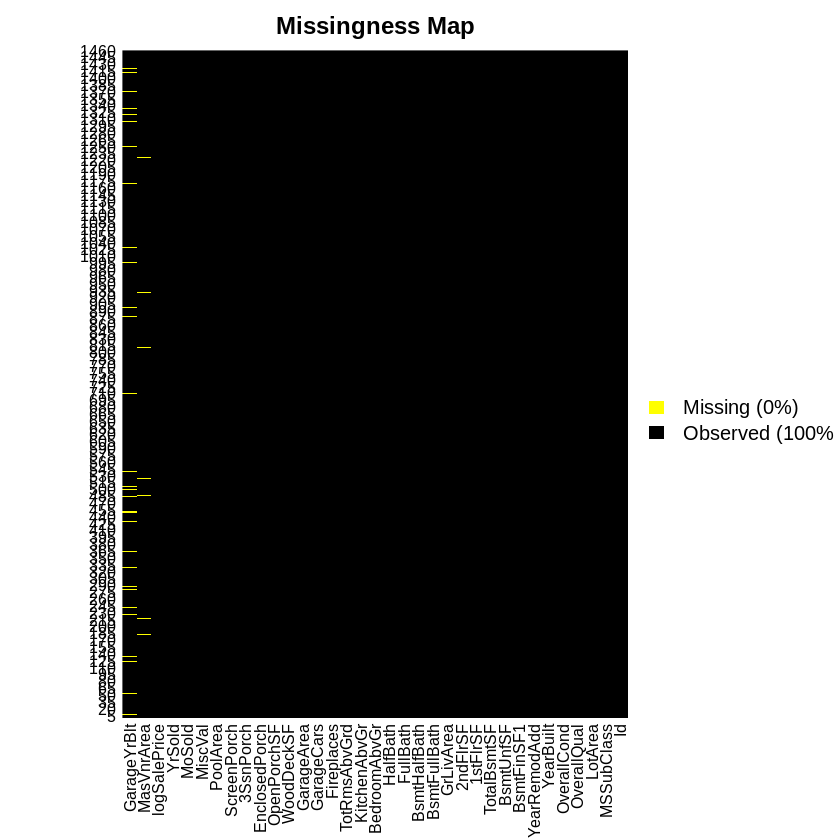

In [230]:
missmap(house_data_num,col=c('yellow','black'),legend=TRUE)

### we see that lotfrontage has quite a bit of missing data. instead of deleting all rows with missing data, lets delete that column and then delete rows 


In [41]:
house_data_num = dplyr::select(house_data_num, -LotFrontage)

In [231]:
house_data_num = drop_na(house_data_num)  #readr library
colnames(house_data_num)[colnames(house_data_num) == "1stFlrSF"] = "first_floor_SF" #rename column because R doesnt like numbers in names


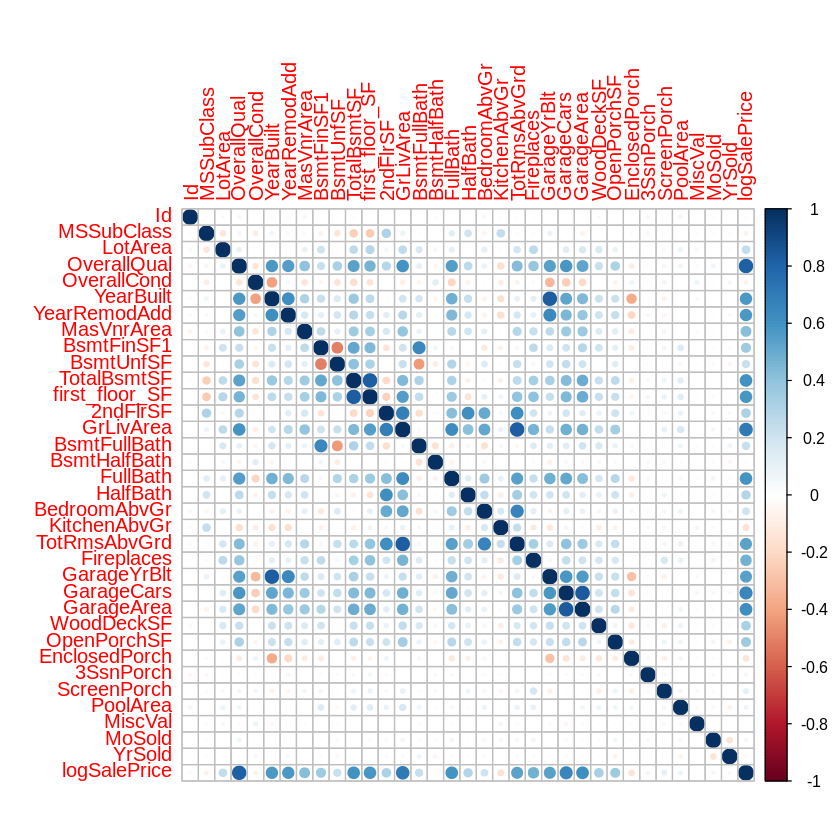

In [232]:
corrplot(cor(house_data_num))

### columns that seem to matter
- OverallQual (high)
- GrLivArea (high)
- GarageCars (high)
- GarageArea (high)

- YearBuilt
- YearRemodAdd
- TotalBsmtSF
- 1stFlrSF
- FullBath
- TotRmsAbvGrd
- Fireplaces
- GarageYrBlt

In [233]:
house_cor_cols = dplyr::select(house_data_num, OverallQual, GrLivArea, GarageCars, GarageArea,YearBuilt, YearRemodAdd, TotalBsmtSF,
                     first_floor_SF, FullBath, TotRmsAbvGrd, Fireplaces, GarageYrBlt, logSalePrice)

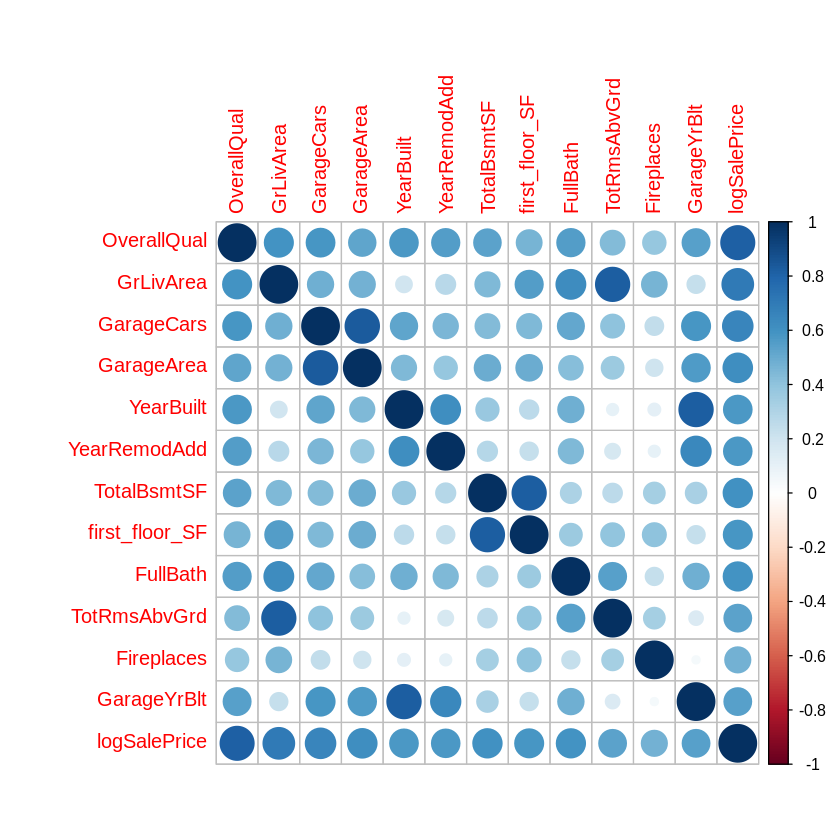

In [234]:
corrplot(cor(house_cor_cols))

### garage cars and area are highly correlated (how surprising) and basement and firstfloor area (also not surprising)  - probably no point including both in a model

In [235]:
options(scipen=999)
dim(house_cor_cols)

[1] 1371   13

In [236]:
# lets finally divide into test and train set
set.seed(123)

split = sample.split(house_cor_cols, SplitRatio=0.95 )
train = subset(house_cor_cols, split==TRUE)
test = subset(house_cor_cols, split==FALSE)

Warning message:
“Length of logical index must be 1 or 1371, not 13”Warning message:
“Length of logical index must be 1 or 1371, not 13”

In [237]:
#lets quickly build two models just to see what happens:

model_1 = lm(logSalePrice ~ OverallQual, data=train)

In [238]:
summary(model_1)


Call:
lm(formula = logSalePrice ~ OverallQual, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.41529 -0.05487  0.00385  0.05539  0.39089 

Coefficients:
            Estimate Std. Error t value            Pr(>|t|)    
(Intercept) 4.619595   0.012737  362.69 <0.0000000000000002 ***
OverallQual 0.099440   0.002013   49.41 <0.0000000000000002 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09643 on 1264 degrees of freedom
Multiple R-squared:  0.6588,	Adjusted R-squared:  0.6586 
F-statistic:  2441 on 1 and 1264 DF,  p-value: < 0.00000000000000022


In [239]:
model_all = lm(logSalePrice ~ ., data=train)

In [240]:
summary(model_all)


Call:
lm(formula = logSalePrice ~ ., data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.90979 -0.03284  0.00242  0.03902  0.21333 

Coefficients:
                   Estimate   Std. Error t value             Pr(>|t|)    
(Intercept)     1.018353064  0.281086232   3.623             0.000303 ***
OverallQual     0.038361727  0.002458122  15.606 < 0.0000000000000002 ***
GrLivArea       0.000075275  0.000008769   8.584 < 0.0000000000000002 ***
GarageCars      0.022125634  0.006271732   3.528             0.000434 ***
GarageArea      0.000046022  0.000021055   2.186             0.029014 *  
YearBuilt       0.001000219  0.000136343   7.336    0.000000000000394 ***
YearRemodAdd    0.001191878  0.000138332   8.616 < 0.0000000000000002 ***
TotalBsmtSF     0.000036941  0.000008963   4.122    0.000040089641623 ***
first_floor_SF  0.000011323  0.000010255   1.104             0.269732    
FullBath       -0.003921526  0.005468820  -0.717             0.473465    
TotRmsAbvGrd   

Subset selection object
Call: regsubsets.formula(logSalePrice ~ ., data = train, nbest = 1, 
    nvmax = NULL, force.in = NULL, force.out = NULL, method = "exhaustive")
12 Variables  (and intercept)
               Forced in Forced out
OverallQual        FALSE      FALSE
GrLivArea          FALSE      FALSE
GarageCars         FALSE      FALSE
GarageArea         FALSE      FALSE
YearBuilt          FALSE      FALSE
YearRemodAdd       FALSE      FALSE
TotalBsmtSF        FALSE      FALSE
first_floor_SF     FALSE      FALSE
FullBath           FALSE      FALSE
TotRmsAbvGrd       FALSE      FALSE
Fireplaces         FALSE      FALSE
GarageYrBlt        FALSE      FALSE
1 subsets of each size up to 12
Selection Algorithm: exhaustive
          OverallQual GrLivArea GarageCars GarageArea YearBuilt YearRemodAdd
1  ( 1 )  "*"         " "       " "        " "        " "       " "         
2  ( 1 )  "*"         "*"       " "        " "        " "       " "         
3  ( 1 )  "*"         "*"       " "   

,OverallQual,GrLivArea,GarageCars,GarageArea,YearBuilt,YearRemodAdd,TotalBsmtSF,first_floor_SF,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt
1 ( 1 ),*,,,,,,,,,,,
2 ( 1 ),*,*,,,,,,,,,,
3 ( 1 ),*,*,,,*,,,,,,,
4 ( 1 ),*,*,,,*,,,*,,,,
5 ( 1 ),*,*,,*,*,,,,,,*,
6 ( 1 ),*,*,,,*,*,*,,,,*,
7 ( 1 ),*,*,*,,*,*,*,,,,*,
8 ( 1 ),*,*,*,,*,*,*,,,*,*,
9 ( 1 ),*,*,*,*,*,*,*,,,*,*,
10 ( 1 ),*,*,*,*,*,*,*,,,*,*,*


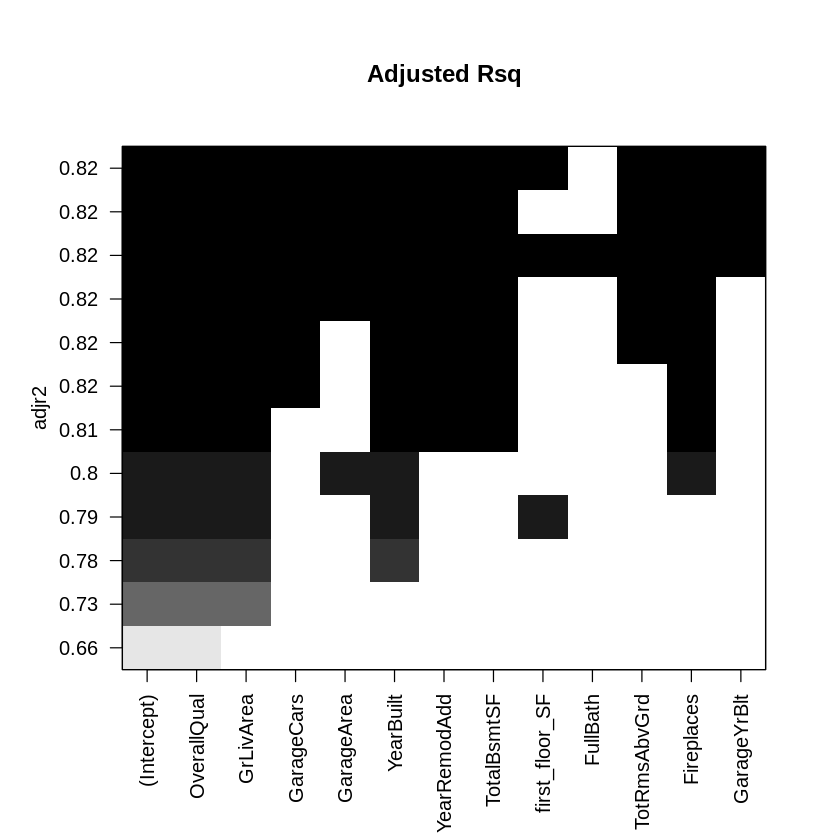

In [241]:
#ok seems like we are in the right track
library(leaps)



regsubsets.out <- regsubsets( logSalePrice ~ .,
                              data = train,
                              nbest = 1,
                              nvmax = NULL,
                              force.in = NULL, force.out = NULL,
                              method = 'exhaustive')
summary(regsubsets.out)
  
as.data.frame(summary(regsubsets.out)$outmat)
plot(regsubsets.out, scale='adjr2', main='Adjusted Rsq')



Subset selection object
Call: regsubsets.formula(logSalePrice ~ ., data = house_data_num, nbest = 1, 
    nvmax = NULL, force.in = NULL, force.out = NULL, method = "exhaustive")
34 Variables  (and intercept)
               Forced in Forced out
Id                 FALSE      FALSE
MSSubClass         FALSE      FALSE
LotArea            FALSE      FALSE
OverallQual        FALSE      FALSE
OverallCond        FALSE      FALSE
YearBuilt          FALSE      FALSE
YearRemodAdd       FALSE      FALSE
MasVnrArea         FALSE      FALSE
BsmtFinSF1         FALSE      FALSE
BsmtUnfSF          FALSE      FALSE
TotalBsmtSF        FALSE      FALSE
first_floor_SF     FALSE      FALSE
`2ndFlrSF`         FALSE      FALSE
GrLivArea          FALSE      FALSE
BsmtFullBath       FALSE      FALSE
BsmtHalfBath       FALSE      FALSE
FullBath           FALSE      FALSE
HalfBath           FALSE      FALSE
BedroomAbvGr       FALSE      FALSE
KitchenAbvGr       FALSE      FALSE
TotRmsAbvGrd       FALSE      FALSE


,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,⋯,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,`3SsnPorch`,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
1 ( 1 ),,,,*,,,,,,,⋯,,,,,,,,,,
2 ( 1 ),,,,*,,,,,,,⋯,,,,,,,,,,
3 ( 1 ),,,,*,,*,,,,,⋯,,,,,,,,,,
4 ( 1 ),,,,*,*,*,,,,,⋯,,,,,,,,,,
5 ( 1 ),,,,*,*,*,,,,,⋯,,,,,,,,,,
6 ( 1 ),,*,,*,*,*,,,,,⋯,,,,,,,,,,
7 ( 1 ),,*,,*,*,*,,,,,⋯,,,,,,,,,,
8 ( 1 ),,*,,*,*,*,,,,,⋯,,,,,,,,,,
9 ( 1 ),,*,*,*,*,*,,,,,⋯,,,,,,,,,,
10 ( 1 ),,*,*,*,*,*,,,,,⋯,,,,,,*,,,,


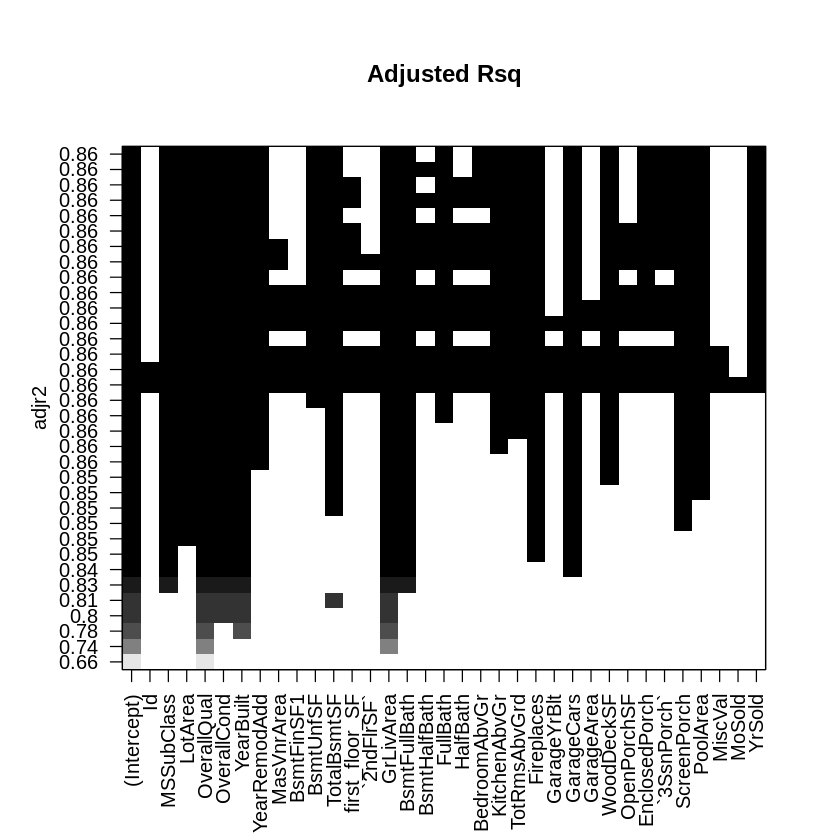

In [278]:
#ok seems like we are in the right track
library(leaps)



regsubsets.out <- regsubsets( logSalePrice ~ .,
                              data = house_data_num,
                              nbest = 1,
                              nvmax = NULL,
                              force.in = NULL, force.out = NULL,
                              method = 'exhaustive')
summary(regsubsets.out)
  
as.data.frame(summary(regsubsets.out)$outmat)
plot(regsubsets.out, scale='adjr2', main='Adjusted Rsq')


###  Ok we see that we get the highest R² with the lowest set of predictors with:
- OverallQual
- GrLivArea
- GarageCars
- YearBuilt
- YearRemodAdd
- TotalBsmtSF
- Fireplaces

In [242]:
# lets use cross validation

set.seed(123)
train.control = trainControl(method = "repeatedcv", number =10, repeats=3)
model_cv = train(logSalePrice ~ OverallQual + GrLivArea +GarageCars +YearBuilt+YearRemodAdd +TotalBsmtSF +Fireplaces,
                data=train, method="lm", trControl = train.control)

In [243]:
print(model_cv)

Linear Regression 

1266 samples
   7 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1138, 1140, 1139, 1139, 1139, 1140, ... 
Resampling results:

  RMSE        Rsquared   MAE       
  0.07112362  0.8145347  0.04853343

Tuning parameter 'intercept' was held constant at a value of TRUE


## let's see whether forward selection with train() tells us anything interesting

In [244]:


model_step = train(logSalePrice ~ OverallQual + GrLivArea +GarageCars +YearBuilt+YearRemodAdd +TotalBsmtSF +Fireplaces,
                data=train, method="leapForward", tuneGrid = data.frame(nvmax = 1:7), trControl = train.control)

In [245]:
summary(model_step)

Subset selection object
7 Variables  (and intercept)
             Forced in Forced out
OverallQual      FALSE      FALSE
GrLivArea        FALSE      FALSE
GarageCars       FALSE      FALSE
YearBuilt        FALSE      FALSE
YearRemodAdd     FALSE      FALSE
TotalBsmtSF      FALSE      FALSE
Fireplaces       FALSE      FALSE
1 subsets of each size up to 7
Selection Algorithm: forward
         OverallQual GrLivArea GarageCars YearBuilt YearRemodAdd TotalBsmtSF
1  ( 1 ) "*"         " "       " "        " "       " "          " "        
2  ( 1 ) "*"         "*"       " "        " "       " "          " "        
3  ( 1 ) "*"         "*"       " "        "*"       " "          " "        
4  ( 1 ) "*"         "*"       " "        "*"       " "          "*"        
5  ( 1 ) "*"         "*"       " "        "*"       " "          "*"        
6  ( 1 ) "*"         "*"       " "        "*"       "*"          "*"        
7  ( 1 ) "*"         "*"       "*"        "*"       "*"          "*"        

In [246]:
print(model_step)

Linear Regression with Forward Selection 

1266 samples
   7 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1138, 1138, 1140, 1139, 1140, 1139, ... 
Resampling results across tuning parameters:

  nvmax  RMSE        Rsquared   MAE       
  1      0.09615710  0.6630936  0.07256625
  2      0.08462432  0.7411773  0.06158212
  3      0.07750711  0.7824357  0.05507129
  4      0.07740512  0.7855834  0.05348434
  5      0.07619088  0.7921202  0.05235877
  6      0.07382498  0.8043730  0.05095982
  7      0.07059524  0.8199814  0.04862081

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was nvmax = 7.


In [83]:
model_step$results
model_step$bestTune

nvmax,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
1,0.09635969,0.6569470,0.07285092,0.007281332,0.05606130,0.005808716
2,0.08587958,0.7310325,0.06220028,0.011690669,0.07225355,0.005216747
3,0.08051186,0.7645967,0.05646470,0.016383923,0.09001360,0.005329083
4,0.08105863,0.7647977,0.05546006,0.019712061,0.10187125,0.004883396
5,0.07853695,0.7787643,0.05383982,0.019615894,0.09955726,0.004520941
6,0.07657910,0.7898205,0.05299124,0.019229794,0.09515661,0.004432052
7,0.07269270,0.8103224,0.04965679,0.018755686,0.09291298,0.004262249


,nvmax
7,7


In [84]:
summary(model_step$finalModel)

Subset selection object
7 Variables  (and intercept)
             Forced in Forced out
OverallQual      FALSE      FALSE
GrLivArea        FALSE      FALSE
GarageCars       FALSE      FALSE
YearBuilt        FALSE      FALSE
YearRemodAdd     FALSE      FALSE
TotalBsmtSF      FALSE      FALSE
Fireplaces       FALSE      FALSE
1 subsets of each size up to 7
Selection Algorithm: forward
         OverallQual GrLivArea GarageCars YearBuilt YearRemodAdd TotalBsmtSF
1  ( 1 ) "*"         " "       " "        " "       " "          " "        
2  ( 1 ) "*"         "*"       " "        " "       " "          " "        
3  ( 1 ) "*"         "*"       " "        "*"       " "          " "        
4  ( 1 ) "*"         "*"       " "        "*"       " "          " "        
5  ( 1 ) "*"         "*"       "*"        "*"       " "          " "        
6  ( 1 ) "*"         "*"       "*"        "*"       "*"          " "        
7  ( 1 ) "*"         "*"       "*"        "*"       "*"          "*"        

### not really, we cannot reduce those 7 predictors anymore and get the same/higher R²

In [281]:
# just out of curiosity, if we use all predictors 

model_step_all = train(logSalePrice ~ .,
                data=train, method="leapForward", tuneGrid = data.frame(nvmax = 1:12), trControl = train.control)

In [282]:
summary(model_step_all)
print(model_step_all)
model_step_all$results
model_step_all$bestTune
summary(model_step_all$finalModel)

Subset selection object
34 Variables  (and intercept)
               Forced in Forced out
Id                 FALSE      FALSE
MSSubClass         FALSE      FALSE
LotArea            FALSE      FALSE
OverallQual        FALSE      FALSE
OverallCond        FALSE      FALSE
YearBuilt          FALSE      FALSE
YearRemodAdd       FALSE      FALSE
MasVnrArea         FALSE      FALSE
BsmtFinSF1         FALSE      FALSE
BsmtUnfSF          FALSE      FALSE
TotalBsmtSF        FALSE      FALSE
first_floor_SF     FALSE      FALSE
`2ndFlrSF`         FALSE      FALSE
GrLivArea          FALSE      FALSE
BsmtFullBath       FALSE      FALSE
BsmtHalfBath       FALSE      FALSE
FullBath           FALSE      FALSE
HalfBath           FALSE      FALSE
BedroomAbvGr       FALSE      FALSE
KitchenAbvGr       FALSE      FALSE
TotRmsAbvGrd       FALSE      FALSE
Fireplaces         FALSE      FALSE
GarageYrBlt        FALSE      FALSE
GarageCars         FALSE      FALSE
GarageArea         FALSE      FALSE
WoodDeckSF

Linear Regression with Forward Selection 

1371 samples
  34 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1233, 1235, 1235, 1235, 1233, 1234, ... 
Resampling results across tuning parameters:

  nvmax  RMSE        Rsquared   MAE       
   1     0.09610775  0.6612288  0.07248385
   2     0.08476745  0.7386962  0.06156036
   3     0.07969424  0.7712389  0.05569831
   4     0.07639105  0.7900527  0.05284537
   5     0.07307376  0.8072683  0.04931638
   6     0.07161525  0.8154509  0.04721984
   7     0.07000596  0.8227259  0.04650628
   8     0.06816498  0.8310692  0.04543595
   9     0.06625529  0.8399454  0.04412490
  10     0.06636763  0.8398528  0.04382930
  11     0.06624425  0.8402230  0.04370707
  12     0.06619739  0.8406772  0.04366592
  13     0.06580690  0.8426779  0.04326570
  14     0.06526206  0.8451797  0.04285511
  15     0.06510427  0.8460192  0.04272046
  16     0.06524172  0.8455237  0.04282370
  17     0

nvmax,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
1,0.09610775,0.6612288,0.07248385,0.005931495,0.04106841,0.004860892
2,0.08476745,0.7386962,0.06156036,0.009383583,0.05130819,0.004407216
3,0.07969424,0.7712389,0.05569831,0.014906097,0.07481856,0.004701011
4,0.07639105,0.7900527,0.05284537,0.016025180,0.07815579,0.004256651
5,0.07307376,0.8072683,0.04931638,0.016895128,0.08113085,0.004224275
6,0.07161525,0.8154509,0.04721984,0.020064535,0.09339760,0.003743959
7,0.07000596,0.8227259,0.04650628,0.019922380,0.09246538,0.003635760
8,0.06816498,0.8310692,0.04543595,0.018953996,0.08783758,0.003759697
9,0.06625529,0.8399454,0.04412490,0.018495981,0.08466505,0.003291746
10,0.06636763,0.8398528,0.04382930,0.017836997,0.08098811,0.003068859


,nvmax
23,23


Subset selection object
34 Variables  (and intercept)
               Forced in Forced out
Id                 FALSE      FALSE
MSSubClass         FALSE      FALSE
LotArea            FALSE      FALSE
OverallQual        FALSE      FALSE
OverallCond        FALSE      FALSE
YearBuilt          FALSE      FALSE
YearRemodAdd       FALSE      FALSE
MasVnrArea         FALSE      FALSE
BsmtFinSF1         FALSE      FALSE
BsmtUnfSF          FALSE      FALSE
TotalBsmtSF        FALSE      FALSE
first_floor_SF     FALSE      FALSE
`2ndFlrSF`         FALSE      FALSE
GrLivArea          FALSE      FALSE
BsmtFullBath       FALSE      FALSE
BsmtHalfBath       FALSE      FALSE
FullBath           FALSE      FALSE
HalfBath           FALSE      FALSE
BedroomAbvGr       FALSE      FALSE
KitchenAbvGr       FALSE      FALSE
TotRmsAbvGrd       FALSE      FALSE
Fireplaces         FALSE      FALSE
GarageYrBlt        FALSE      FALSE
GarageCars         FALSE      FALSE
GarageArea         FALSE      FALSE
WoodDeckSF

### apparently using 11/12 predictors give a slightly better R² - doubtful that it's significant so we will stick to out model with 7 predictors. let's predict!

In [253]:
test$predicted.logSalePrice = predict(model_step,test)


In [254]:
head(test)

OverallQual,GrLivArea,GarageCars,GarageArea,YearBuilt,YearRemodAdd,TotalBsmtSF,first_floor_SF,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,logSalePrice,predicted.logSalePrice
5,1040,1,384,1965,1965,1040,1040,1,5,0,1965,5.112270,5.068354
5,1060,2,572,1976,1976,1040,1060,1,6,1,1976,5.113609,5.154208
5,1097,2,672,1994,1995,1097,1097,1,6,0,1995,5.161368,5.163095
6,1176,2,528,1934,1950,816,816,1,6,1,1985,5.058805,5.130029
7,2034,2,645,1997,1998,1057,1057,2,8,0,1998,5.341435,5.326055
5,1285,1,240,1948,2001,672,1072,1,6,0,1948,5.103804,5.099485


In [255]:
logSalePrice_act = test$logSalePrice
logSalePrice_pred = test$predicted.logSalePrice

In [256]:
r2_ = R2(logSalePrice_pred, logSalePrice_act)

In [257]:
r2_

[1] 0.8442756

In [258]:
#lets use all predictors just for fun
test$predicted.logSalePrice2 = predict(model_step_all, test)

In [259]:
logSalePrice_pred2 = test$predicted.logSalePrice2
r2_ = R2(logSalePrice_pred2, logSalePrice_act)
r2_

[1] 0.8460917

In [99]:
# yep, no point using all predictors

### ok now let's use stepAIC and use it on all of the numerical data and see whether it gives us a different result than what we did manually with correlation plot

In [260]:
set.seed(123)

split = sample.split(house_data_num, SplitRatio=0.95 )
train2 = subset(house_data_num, split==TRUE)
test2 = subset(house_data_num, split==FALSE)

Warning message:
“Length of logical index must be 1 or 1371, not 35”Warning message:
“Length of logical index must be 1 or 1371, not 35”

In [261]:
# another way to do stepwise selection

In [262]:


lm.min <- lm(logSalePrice ~ 1, data=train2)
lm.max <- lm(logSalePrice ~ ., data=train2)


In [264]:
scp <- list(lower = lm.min, upper = lm.max)

lm.selected <- stepAIC(lm.min, direction = 'forward', scope = scp, steps = 18)
#after playing around a bit I managed to find the number "18" with 18 more or less statistically significant predictors
summary(lm.selected)

Start:  AIC=-4664.96
logSalePrice ~ 1

                 Df Sum of Sq    RSS     AIC
+ OverallQual     1   23.1387 11.860 -6062.1
+ GrLivArea       1   17.4890 17.510 -5558.4
+ GarageCars      1   15.0155 19.983 -5387.6
+ GarageArea      1   13.1727 21.826 -5273.5
+ TotalBsmtSF     1   12.5468 22.452 -5237.0
+ FullBath        1   12.4309 22.568 -5230.3
+ first_floor_SF  1   11.9641 23.035 -5203.8
+ YearBuilt       1   11.4244 23.575 -5173.9
+ YearRemodAdd    1   11.3907 23.608 -5172.0
+ TotRmsAbvGrd    1   10.5353 24.464 -5126.0
+ GarageYrBlt     1   10.0397 24.959 -5100.1
+ Fireplaces      1    7.9415 27.057 -4995.7
+ MasVnrArea      1    6.4626 28.536 -4926.9
+ OpenPorchSF     1    4.4689 30.530 -4839.6
+ BsmtFinSF1      1    4.2696 30.729 -4831.2
+ `2ndFlrSF`      1    3.7852 31.214 -4811.0
+ WoodDeckSF      1    3.5868 31.412 -4802.8
+ HalfBath        1    3.2199 31.779 -4787.7
+ LotArea         1    2.1655 32.833 -4745.5
+ BsmtFullBath    1    1.8253 33.174 -4732.2
+ BsmtUnfSF     


Step:  AIC=-6925.11
logSalePrice ~ OverallQual + GrLivArea + YearBuilt + OverallCond + 
    TotalBsmtSF + GarageCars

                 Df Sum of Sq    RSS     AIC
+ Fireplaces      1   0.32305 5.7148 -6994.2
+ BsmtFullBath    1   0.27499 5.7628 -6983.4
+ MSSubClass      1   0.21397 5.8239 -6969.8
+ LotArea         1   0.19904 5.8388 -6966.5
+ BsmtUnfSF       1   0.18055 5.8573 -6962.4
+ KitchenAbvGr    1   0.16228 5.8755 -6958.3
+ BsmtFinSF1      1   0.13642 5.9014 -6952.7
+ ScreenPorch     1   0.11458 5.9232 -6947.9
+ WoodDeckSF      1   0.07300 5.9648 -6938.8
+ PoolArea        1   0.03788 6.0000 -6931.2
+ first_floor_SF  1   0.03418 6.0036 -6930.5
+ `2ndFlrSF`      1   0.03021 6.0076 -6929.6
+ YearRemodAdd    1   0.02283 6.0150 -6928.0
+ TotRmsAbvGrd    1   0.01533 6.0225 -6926.4
+ GarageYrBlt     1   0.01324 6.0246 -6925.9
<none>                        6.0378 -6925.1
+ Id              1   0.00779 6.0300 -6924.8
+ OpenPorchSF     1   0.00663 6.0312 -6924.5
+ EnclosedPorch   1   0.00


Step:  AIC=-7141.82
logSalePrice ~ OverallQual + GrLivArea + YearBuilt + OverallCond + 
    TotalBsmtSF + GarageCars + Fireplaces + BsmtFullBath + MSSubClass + 
    LotArea + ScreenPorch + YearRemodAdd

                 Df Sum of Sq    RSS     AIC
+ PoolArea        1  0.048900 5.0101 -7152.4
+ WoodDeckSF      1  0.037742 5.0212 -7149.5
+ KitchenAbvGr    1  0.030799 5.0282 -7147.7
+ TotRmsAbvGrd    1  0.024991 5.0340 -7146.2
+ FullBath        1  0.019597 5.0394 -7144.8
+ YrSold          1  0.017730 5.0412 -7144.4
+ EnclosedPorch   1  0.011958 5.0470 -7142.9
<none>                        5.0590 -7141.8
+ BsmtUnfSF       1  0.007807 5.0512 -7141.8
+ BsmtFinSF1      1  0.005368 5.0536 -7141.2
+ `3SsnPorch`     1  0.003771 5.0552 -7140.8
+ Id              1  0.003690 5.0553 -7140.8
+ OpenPorchSF     1  0.002326 5.0566 -7140.4
+ BsmtHalfBath    1  0.000994 5.0580 -7140.1
+ MiscVal         1  0.000427 5.0585 -7139.9
+ MasVnrArea      1  0.000402 5.0586 -7139.9
+ GarageArea      1  0.000399 5


Call:
lm(formula = logSalePrice ~ OverallQual + GrLivArea + YearBuilt + 
    OverallCond + TotalBsmtSF + GarageCars + Fireplaces + BsmtFullBath + 
    MSSubClass + LotArea + ScreenPorch + YearRemodAdd + PoolArea + 
    WoodDeckSF + KitchenAbvGr + TotRmsAbvGrd + FullBath + YrSold, 
    data = train2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.79415 -0.03046  0.00041  0.03246  0.22288 

Coefficients:
                  Estimate    Std. Error t value             Pr(>|t|)    
(Intercept)   7.4789574124  2.6233104019   2.851             0.004429 ** 
OverallQual   0.0369873115  0.0022154183  16.695 < 0.0000000000000002 ***
GrLivArea     0.0000809640  0.0000076638  10.564 < 0.0000000000000002 ***
YearBuilt     0.0012227265  0.0001051148  11.632 < 0.0000000000000002 ***
OverallCond   0.0208050772  0.0019957636  10.425 < 0.0000000000000002 ***
TotalBsmtSF   0.0000266681  0.0000056389   4.729  0.00000250402408118 ***
GarageCars    0.0343965707  0.0037829193   9.093 < 0.00000000

In [265]:
features = colnames(model.matrix(lm.selected))
features = features[-1] #delete intercept
features

[1] "OverallQual"  "GrLivArea"    "YearBuilt"    "OverallCond"  "TotalBsmtSF" 
 [6] "GarageCars"   "Fireplaces"   "BsmtFullBath" "MSSubClass"   "LotArea"     
[11] "ScreenPorch"  "YearRemodAdd" "PoolArea"     "WoodDeckSF"   "KitchenAbvGr"
[16] "TotRmsAbvGrd" "FullBath"     "YrSold"

In [268]:
model_18 = train(logSalePrice ~ OverallQual + GrLivArea + YearBuilt +
                   OverallCond+MSSubClass+BsmtFullBath+GarageCars+
                   Fireplaces+LotArea+ScreenPorch+PoolArea+TotalBsmtSF+
                   WoodDeckSF+FullBath+KitchenAbvGr+ TotRmsAbvGrd+ 
                   YearRemodAdd+EnclosedPorch,data=train2, method="lm", trControl = train.control)

In [269]:
print(model_18)

Linear Regression 

1293 samples
  18 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 1164, 1164, 1162, 1162, 1164, 1164, ... 
Resampling results:

  RMSE        Rsquared   MAE       
  0.06275099  0.8553928  0.04209028

Tuning parameter 'intercept' was held constant at a value of TRUE


In [270]:
summary(model_18)


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.79319 -0.02990  0.00002  0.03270  0.22700 

Coefficients:
                   Estimate    Std. Error t value             Pr(>|t|)    
(Intercept)    1.2413085050  0.2484738994   4.996   0.0000006676459982 ***
OverallQual    0.0364659922  0.0022283183  16.365 < 0.0000000000000002 ***
GrLivArea      0.0000800861  0.0000076791  10.429 < 0.0000000000000002 ***
YearBuilt      0.0013132474  0.0001118113  11.745 < 0.0000000000000002 ***
OverallCond    0.0212260980  0.0020106070  10.557 < 0.0000000000000002 ***
MSSubClass    -0.0002773401  0.0000486058  -5.706   0.0000000143768583 ***
BsmtFullBath   0.0292517429  0.0037354183   7.831   0.0000000000000101 ***
GarageCars     0.0346125246  0.0037825544   9.151 < 0.0000000000000002 ***
Fireplaces     0.0210091942  0.0032041123   6.557   0.0000000000796055 ***
LotArea        0.0000008017  0.0000001870   4.287   0.0000194335790064 ***
ScreenPorc

In [283]:
test2$predicted.logSalePrice3 = predict(model_18, test2)
logSalePrice_pred3 = test2$predicted.logSalePrice3
logSalePrice_act = test2$logSalePrice
r2_ = R2(logSalePrice_pred3, logSalePrice_act)
r2_

[1] 0.8478621

In [284]:
head(test2)

Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,⋯,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,logSalePrice,predicted.logSalePrice3
24,120,4224,5,7,1976,1976,0,840,200,⋯,110,0,0,0,0,0,6,2007,5.113609,5.174488
31,70,8500,4,4,1920,1950,0,0,649,⋯,54,172,0,0,0,0,7,2008,4.602060,4.937460
61,20,13072,6,5,2004,2004,0,941,217,⋯,50,0,0,0,0,0,5,2006,5.198657,5.236036
68,20,10665,7,5,2003,2003,167,1013,440,⋯,29,0,0,0,0,0,6,2007,5.354108,5.335830
99,30,10625,5,5,1920,1950,0,108,350,⋯,0,77,0,0,0,400,5,2010,4.919078,4.952234
107,30,10800,4,7,1885,1995,0,0,641,⋯,0,0,0,0,0,450,8,2007,5.000000,4.961116


In [287]:
test_kaggle = read.csv("data/test.csv")
dim(test_kaggle)

[1] 1459   76

       Id         MSSubClass        MSZoning     LotFrontage    
 Min.   :1461   Min.   : 20.00   C (all):  15   Min.   : 21.00  
 1st Qu.:1826   1st Qu.: 20.00   FV     :  74   1st Qu.: 58.00  
 Median :2190   Median : 50.00   RH     :  10   Median : 67.00  
 Mean   :2190   Mean   : 57.38   RL     :1114   Mean   : 68.58  
 3rd Qu.:2554   3rd Qu.: 70.00   RM     : 242   3rd Qu.: 80.00  
 Max.   :2919   Max.   :190.00   NA's   :   4   Max.   :200.00  
                                                NA's   :227     
    LotArea       Street     LotShape  LandContour  Utilities      LotConfig   
 Min.   : 1470   Grvl:   6   IR1:484   Bnk:  54    AllPub:1457   Corner : 248  
 1st Qu.: 7391   Pave:1453   IR2: 35   HLS:  70    NA's  :   2   CulDSac:  82  
 Median : 9399               IR3:  6   Low:  24                  FR2    :  38  
 Mean   : 9819               Reg:934   Lvl:1311                  FR3    :  10  
 3rd Qu.:11518                                                   Inside :1081  


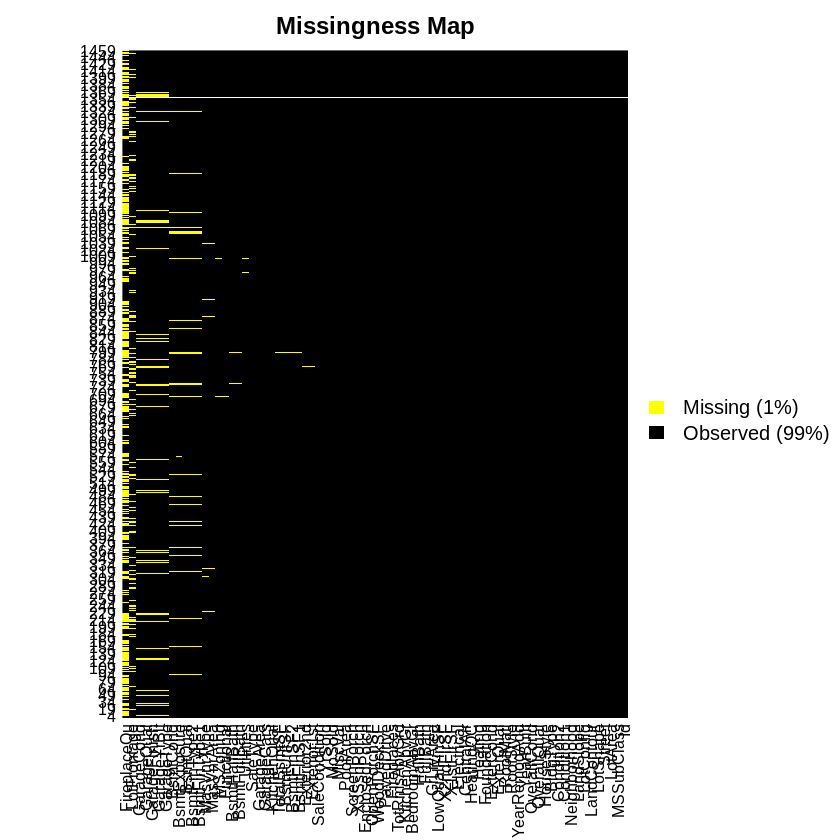

In [274]:
missmap(test_kaggle,col=c('yellow','black'),legend=TRUE)
summary(test_kaggle)

In [289]:
test_kaggle$predicted2 = predict(model_18, newdata=test_kaggle, na.action=na.pass)
head(test_kaggle)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,⋯,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,predicted2
1461,20,RH,80,11622,Pave,Reg,Lvl,AllPub,Inside,⋯,0,0,120,0,0,6,2010,WD,Normal,5.076307
1462,20,RL,81,14267,Pave,IR1,Lvl,AllPub,Corner,⋯,0,0,0,0,12500,6,2010,WD,Normal,5.155758
1463,60,RL,74,13830,Pave,IR1,Lvl,AllPub,Inside,⋯,0,0,0,0,0,3,2010,WD,Normal,5.225892
1464,60,RL,78,9978,Pave,IR1,Lvl,AllPub,Inside,⋯,0,0,0,0,0,6,2010,WD,Normal,5.293409
1465,120,RL,43,5005,Pave,IR1,HLS,AllPub,Inside,⋯,0,0,144,0,0,1,2010,WD,Normal,5.269549
1466,60,RL,75,10000,Pave,IR1,Lvl,AllPub,Corner,⋯,0,0,0,0,0,4,2010,WD,Normal,5.254194


In [290]:
test_kaggle$SalePrice = test_kaggle$predicted^10
test_kaggle

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,⋯,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,predicted2,SalePrice
1461,20,RH,80,11622,Pave,Reg,Lvl,AllPub,Inside,⋯,0,120,0,0,6,2010,WD,Normal,5.076307,11362637
1462,20,RL,81,14267,Pave,IR1,Lvl,AllPub,Corner,⋯,0,0,0,12500,6,2010,WD,Normal,5.155758,13271649
1463,60,RL,74,13830,Pave,IR1,Lvl,AllPub,Inside,⋯,0,0,0,0,3,2010,WD,Normal,5.225892,15191618
1464,60,RL,78,9978,Pave,IR1,Lvl,AllPub,Inside,⋯,0,0,0,0,6,2010,WD,Normal,5.293409,17272484
1465,120,RL,43,5005,Pave,IR1,HLS,AllPub,Inside,⋯,0,144,0,0,1,2010,WD,Normal,5.269549,16509509
1466,60,RL,75,10000,Pave,IR1,Lvl,AllPub,Corner,⋯,0,0,0,0,4,2010,WD,Normal,5.254194,16034693
1467,20,RL,NA,7980,Pave,IR1,Lvl,AllPub,Inside,⋯,0,0,0,500,3,2010,WD,Normal,5.300284,17498109
1468,60,RL,63,8402,Pave,IR1,Lvl,AllPub,Inside,⋯,0,0,0,0,5,2010,WD,Normal,5.239174,15582191
1469,20,RL,85,10176,Pave,Reg,Lvl,AllPub,Inside,⋯,0,0,0,0,2,2010,WD,Normal,5.291452,17208706
1470,20,RL,70,8400,Pave,Reg,Lvl,AllPub,Corner,⋯,0,0,0,0,4,2010,WD,Normal,5.072940,11287484


In [277]:
write.csv(test_kaggle, file = "predicted2.csv")

# lets use all predictors now (not just numerical)

In [201]:
house_data_raw

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,logSalePrice
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,⋯,NA,NA,NA,0,2,2008,WD,Normal,208500,5.319106
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,⋯,NA,NA,NA,0,5,2007,WD,Normal,181500,5.258877
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,⋯,NA,NA,NA,0,9,2008,WD,Normal,223500,5.349278
4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,⋯,NA,NA,NA,0,2,2006,WD,Abnorml,140000,5.146128
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,⋯,NA,NA,NA,0,12,2008,WD,Normal,250000,5.397940
6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,⋯,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000,5.155336
7,20,RL,75,10084,Pave,NA,Reg,Lvl,AllPub,⋯,NA,NA,NA,0,8,2007,WD,Normal,307000,5.487138
8,60,RL,NA,10382,Pave,NA,IR1,Lvl,AllPub,⋯,NA,NA,Shed,350,11,2009,WD,Normal,200000,5.301030
9,50,RM,51,6120,Pave,NA,Reg,Lvl,AllPub,⋯,NA,NA,NA,0,4,2008,WD,Abnorml,129900,5.113609
10,190,RL,50,7420,Pave,NA,Reg,Lvl,AllPub,⋯,NA,NA,NA,0,1,2008,WD,Normal,118000,5.071882


Parsed with column specification:
cols(
  .default = col_character(),
  Id = col_integer(),
  MSSubClass = col_integer(),
  LotArea = col_integer(),
  OverallQual = col_integer(),
  OverallCond = col_integer(),
  YearBuilt = col_integer(),
  YearRemodAdd = col_integer(),
  MasVnrArea = col_integer(),
  BsmtFinSF1 = col_integer(),
  BsmtUnfSF = col_integer(),
  TotalBsmtSF = col_integer(),
  `1stFlrSF` = col_integer(),
  `2ndFlrSF` = col_integer(),
  GrLivArea = col_integer(),
  BsmtFullBath = col_integer(),
  BsmtHalfBath = col_integer(),
  FullBath = col_integer(),
  HalfBath = col_integer(),
  BedroomAbvGr = col_integer(),
  KitchenAbvGr = col_integer()
  # ... with 15 more columns
)
See spec(...) for full column specifications.


Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,⋯,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,⋯,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,⋯,0,0,0,0,0,5,2007,WD,Normal,181500
3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,⋯,0,0,0,0,0,9,2008,WD,Normal,223500
4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,⋯,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,⋯,0,0,0,0,0,12,2008,WD,Normal,250000
6,50,RL,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,⋯,0,320,0,0,700,10,2009,WD,Normal,143000


Warning message in if (class(obj) == "amelia") {:
“the condition has length > 1 and only the first element will be used”Warning message:
“Unknown or uninitialised column: 'arguments'.”Warning message:
“Unknown or uninitialised column: 'arguments'.”Warning message:
“Unknown or uninitialised column: 'imputations'.”

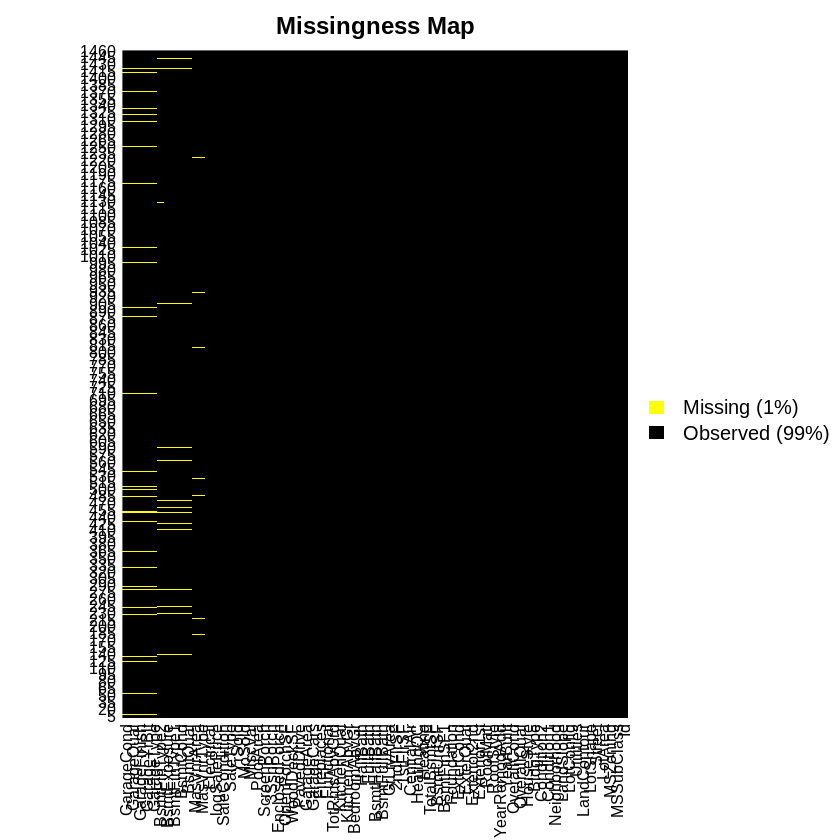

In [215]:
house_data_raw = read_csv("data/train.csv")
head(house_data_raw)
house_data_raw$logSalePrice = log10(house_data_raw$SalePrice)

house_data_raw = dplyr::select(house_data_raw, -SalePrice)
missmap(house_data_raw,col=c('yellow','black'),legend=TRUE)

In [219]:
str(house_data_raw)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	1338 obs. of  73 variables:
 $ Id            : int  1 2 3 4 5 6 7 8 9 10 ...
 $ MSSubClass    : int  60 20 60 70 60 50 20 60 50 190 ...
 $ MSZoning      : chr  "RL" "RL" "RL" "RL" ...
 $ LotArea       : int  8450 9600 11250 9550 14260 14115 10084 10382 6120 7420 ...
 $ Street        : chr  "Pave" "Pave" "Pave" "Pave" ...
 $ LotShape      : chr  "Reg" "Reg" "IR1" "IR1" ...
 $ LandContour   : chr  "Lvl" "Lvl" "Lvl" "Lvl" ...
 $ Utilities     : chr  "AllPub" "AllPub" "AllPub" "AllPub" ...
 $ LotConfig     : chr  "Inside" "FR2" "Inside" "Corner" ...
 $ LandSlope     : chr  "Gtl" "Gtl" "Gtl" "Gtl" ...
 $ Neighborhood  : chr  "CollgCr" "Veenker" "CollgCr" "Crawfor" ...
 $ Condition1    : chr  "Norm" "Feedr" "Norm" "Norm" ...
 $ Condition2    : chr  "Norm" "Norm" "Norm" "Norm" ...
 $ BldgType      : chr  "1Fam" "1Fam" "1Fam" "1Fam" ...
 $ HouseStyle    : chr  "2Story" "1Story" "2Story" "2Story" ...
 $ OverallQual   : int  7 6 7 7 8 5 8 7 7 5 ...
 $ Ov

In [216]:
house_data_raw = drop_na(house_data_raw)  #readr library
colnames(house_data_raw)[colnames(house_data_raw) == "1stFlrSF"] = "first_floor_SF" #rename column because R doesnt like numbers in names
colnames(house_data_raw)[colnames(house_data_raw) == "2stFlrSF"] = "second_floor_SF" #rename column because R doesnt like numbers in names


In [217]:
# lets finally divide into test and train set
set.seed(123)

split = sample.split(house_data_raw, SplitRatio=0.8 )
train = subset(house_data_raw, split==TRUE)
test = subset(house_data_raw, split==FALSE)

Warning message:
“Length of logical index must be 1 or 1338, not 73”Warning message:
“Length of logical index must be 1 or 1338, not 73”

In [218]:
model_all = lm(logSalePrice ~ ., data=train)
summary(model_all)

ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels
